In [49]:
from scipy.io import loadmat
import numpy as np

def load_mat(filename):

    print(f"Loading {filename}")

    filepath = f'./data/{filename}'

    # Load the .mat file
    data = loadmat(filepath)

    # Inspect the loaded data
    print(f"{data.keys()} \n")
    
    return data

In [50]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.optimize import curve_fit
from scipy.signal import correlate
import scipy

def noise(show):

    # load and print .mat data
    CoordinatesTest = load_mat('CoordinatesTest.mat')
    ImageTest = load_mat('ImageTest.mat')

    CoordinatesTest_i = CoordinatesTest["i_molecules"]
    CoordinatesTest_j = CoordinatesTest["j_molecules"]
    ImageTest = ImageTest["ImageTest"]

    # Find the minimum and maximum values in the array
    min_val = np.min(ImageTest)
    max_val = np.max(ImageTest)

    # Normalize the array to the range [0, 255]
    ImageTest = 255 * (ImageTest - min_val) / (max_val - min_val)

    if show:
        plt.imshow(ImageTest)
        plt.title("Image Test")
        plt.scatter(CoordinatesTest_j, CoordinatesTest_i, s=5, c="red", marker="o", label="True coordinates")
        rect = patches.Rectangle((2, 52), 96, 16, linewidth=2, edgecolor="yellow", facecolor='none',label="Noise region")
        plt.gca().add_patch(rect)
        plt.colorbar()
        plt.legend()
        plt.show()
    
    NoiseTest = ImageTest[52:68,2:96]
    
    if show:
        plt.imshow(NoiseTest)
        plt.colorbar()
        plt.title("Noise Test")
        plt.show()

        plt.plot(NoiseTest.ravel())
        plt.title("Noise Test 1D")
        plt.show()

    # Histogram of noise distribution and gaussian fit

    data = NoiseTest.ravel() - NoiseTest.ravel().mean()
    NoiseTest_hist, bin_edges = np.histogram(data, bins="auto", density=True)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    if show:
        plt.bar(bin_edges[:-1], NoiseTest_hist, width=np.diff(bin_edges), color="red", edgecolor="black", align="edge")

    # Step 3: Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Step 4: Fit the Gaussian curve to the histogram data
    # Provide initial estimates for amplitude, mean, and stddev
    popt, _ = curve_fit(gaussian, bin_centers, NoiseTest_hist, p0=[1, 0, 1])

    print(f"Fitted gaussian parameters, (amp, mean, stddev): {popt}")

    # Step 5: Plot the fitted Gaussian curve
    x_vals = np.linspace(-20, 20, 1000)

    if show: 
        plt.plot(x_vals, gaussian(x_vals, *popt), color='blue', linestyle='--', linewidth=2, label='Fitted Gaussian')

        # Additional plot settings
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
        plt.title(f"Histogram of distributed noise and Fitted Gaussian Curve")
        plt.show()

        ocor = correlate(data, data, mode='same', method="fft")
        plt.plot(ocor)
        plt.title("Cross correlation of Noise")
        plt.show()

    return popt

In [51]:
from scipy.optimize import fmin
from scipy.special import erf
from scipy.signal import correlate2d
from math import sqrt, pi

def r_ij(theta_x, theta_y, X, Y, w):
    """Computes the localization of a point according to the inte gration of a gaussian function of mean the true position. Needs sigma_r as global variable.

    Args:
        x (ndarray): position (integer)
        theta (scalar): true position

    Returns:
        list: localization, function of a pitch dx
    """
    sigma_r = w /2 /sqrt(2*np.log(2))
    res = 1 /4 * ( erf((np.add(X, np.ones(X.shape)) - theta_x) /(sqrt(2) * sigma_r)) - erf(((X) - theta_x) /(sqrt(2) * sigma_r)) ) * ( erf((np.add(Y, np.ones(Y.shape)) - theta_y) /(sqrt(2) * sigma_r)) - erf(((Y) - theta_y) /(sqrt(2) * sigma_r)) ) # (x+1) * dx & x * dx

    return res

def logLLH(vars, constants):
    """Computes the log-likelyhood of a noisy signal for a specific alpha.

    Args:
        alpha (scalar): decay rate of the determinist "clean signal""Données pour les TP-20240920"
        noisy (ndarray): noisy signal.
        x (list): time serie. 

    Returns:
        scalar: log-likelyhood for a specific decay rate and for a selected noisy signal.
    """

    theta_x, theta_y = vars
    noisy, sigma_b, w = constants

    I = noisy.shape[0]
    J = noisy.shape[1]

    x = np.asarray([j for j in range(J)])
    y = np.asarray([i for i in range(I)])
    X, Y = np.meshgrid(x, y)

    clean = r_ij(theta_x, theta_y, X, Y, w)

    m = noisy.mean()
    LLH = correlate2d(noisy, clean, mode="same", boundary="fill", fillvalue=m)

    return LLH

def computeLLH(image, sigma_b, w):

    I = image.shape[0]
    J = image.shape[1]

    vars = int(J/2), int(I/2)
    constants = image, sigma_b, w

    LLH = logLLH(vars, constants)

    # Find the minimum and maximum values in the array
    min_val = np.min(LLH)
    max_val = np.max(LLH)

    # Normalize the array to the range [0, 255]
    LLH = 255 * (LLH - min_val) / (max_val - min_val)

    return LLH

In [52]:
import sys
import pandas as pd 

def exportLLHs(gaussian_param):

    # Start analysis
    a = gaussian_param[0]
    m = gaussian_param[1]
    sigma_b = gaussian_param[2]
    w = 2.22

    image_list = load_mat('ImagesPALM.mat')
    image_list = np.asarray(image_list["ImagesPALM"])
    image_list = image_list.transpose(2,0,1)

    N = len(image_list)

    llh_list = []
    iter = N
 
    for i in range(iter):
        image = image_list[i]
        llh = computeLLH(image, sigma_b, w)
        llh_list.append(llh)

    # Flatten each 2D array and store as rows
    flattened_rows = [arr.flatten() for arr in llh_list]

    # Create a DataFrame from the flattened rows
    df = pd.DataFrame(flattened_rows)

    # Save to CSV (without index to make it easier to load later)
    df.to_csv("data/llh_PALM.csv", index=False)
    
if __name__=="__main__":
    gaussian_param = noise(False)
    # exportLLHs(gaussian_param)

Loading CoordinatesTest.mat
dict_keys(['__header__', '__version__', '__globals__', 'i_molecules', 'j_molecules']) 

Loading ImageTest.mat
dict_keys(['__header__', '__version__', '__globals__', 'ImageTest']) 

Fitted gaussian parameters, (amp, mean, stddev): [0.06849057 0.06242053 5.78419291]


y max 48
x max 78


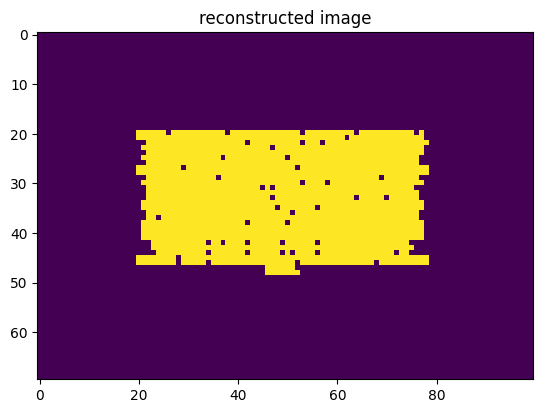

In [53]:
import itertools

def PALM_LLH(LLH):
    
    max = np.max(LLH)
    step = 2

    x = []
    y = []
    locations = []

    while max>= 220:

        # Find the global maximum value and its index (flattened)
        max_index_flat = np.argmax(LLH)

        # Convert the flattened index to 2D coordinates
        loc_y, loc_x = np.unravel_index(max_index_flat, LLH.shape)
        max_value = LLH[loc_y, loc_x]

        y.append(loc_y)
        x.append(loc_x)
        locations.append(y)
        locations.append(x)

        LLH[loc_y-step:loc_y+step,loc_x-step:loc_x+step] = 0

        max = np.max(LLH)

    return locations

def reconstruct(r, y, x):

    frame = np.zeros((r*70,r*100))
    print(f"y max {max(y)}")
    print(f"x max {max(x)}")

    for i in range(len(x)):
        frame[y[i], x[i]] = 255

    plt.imshow(frame)
    plt.title("reconstructed image")
    plt.show()


if __name__=="__main__":
    # Load the CSV file into a DataFrame
    df = pd.read_csv("data/llh_PALM.csv")

    # Reshape each row back to its original shape (70, 100)
    reshaped_arrays = [row.values.reshape(70, 100) for _, row in df.iterrows()]

    y = []
    x = []

    for arr in reshaped_arrays:
        locs = PALM_LLH(arr)

        y.append(locs[0])
        x.append(locs[1])

    y = list(itertools.chain(*y))
    x = list(itertools.chain(*x))
    r = 1
    reconstruct(r, y, x)

Loading CoordinatesTest.mat
dict_keys(['__header__', '__version__', '__globals__', 'i_molecules', 'j_molecules']) 

Loading ImageTest.mat
dict_keys(['__header__', '__version__', '__globals__', 'ImageTest']) 

Fitted gaussian parameters, (amp, mean, stddev): [0.06849057 0.06242053 5.78419291]
999


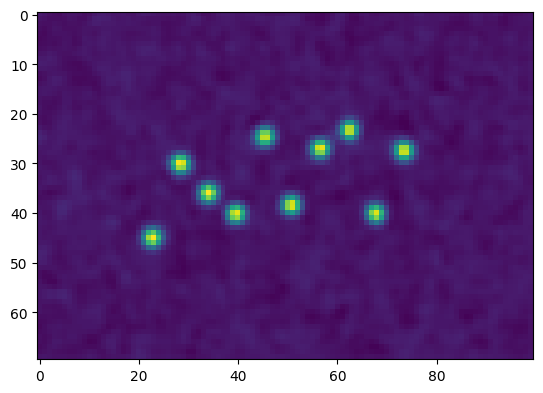

Processing items:   0%|          | 0/999 [00:00<?, ?item/s]

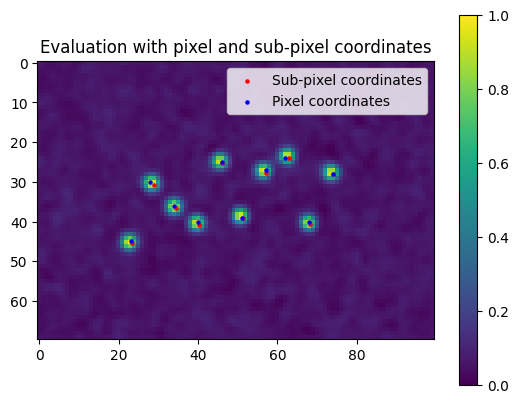

y max 455
x max 739


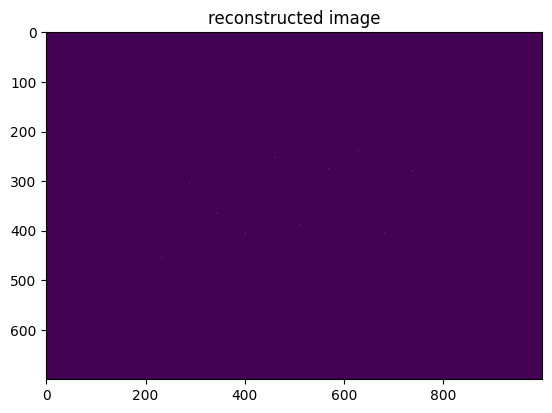

Processing items:   0%|          | 1/999 [00:00<12:27,  1.34item/s]

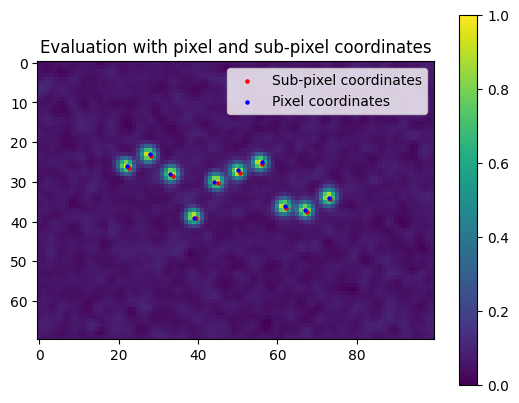

Processing items:   0%|          | 2/999 [00:01<11:50,  1.40item/s]

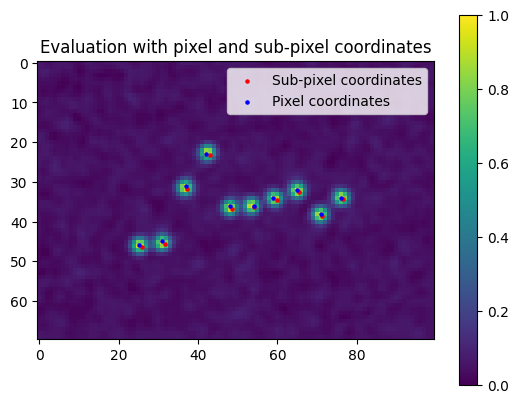

Processing items:   0%|          | 3/999 [00:02<11:42,  1.42item/s]

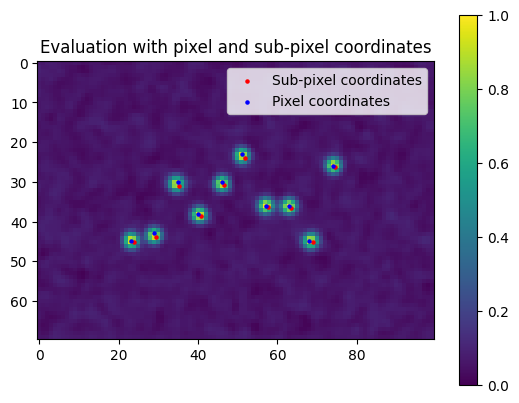

Processing items:   0%|          | 4/999 [00:02<12:23,  1.34item/s]


KeyboardInterrupt: 

In [59]:
def logLLH_detailed(vars, constants):
    """Computes the log-likelyhood of a noisy signal for a specific alpha.

    Args:
        alpha (scalar): decay rate of the determinist "clean signal""Données pour les TP-20240920"
        noisy (ndarray): noisy signal.
        x (list): time serie. 

    Returns:
        scalar: log-likelyhood for a specific decay rate and for a selected noisy signal.
    """

    theta_x, theta_y = vars
    noisy, sigma_b, w = constants

    I = noisy.shape[0]
    J = noisy.shape[1]

    x = np.asarray([j for j in range(J)])
    y = np.asarray([i for i in range(I)])
    X, Y = np.meshgrid(x, y)

    clean = r_ij(theta_y, theta_x, X, Y, w)

    sum = 0

    for i in range(I):
        sum += np.sum(np.add( noisy[i,:], -clean[i,:])**2)

    LLH = - I * J /2 * np.log(2 * pi * sigma_b**2) - 1 /2 /sigma_b**2 * sum

    return -LLH

def fmaxLLH(noisy, sigma_b, w, initial_guess):
    """finds the minimum of the log-likelyhood function considered as a function of alpha.

    Args:
        alpha_0 (scalar): initial guess, comprised in [0,1]
        noisy (ndarray): noisy signal considered.
        
    Returns:
        scalar: alpha_0 such as the log-likelyhood is minimum.    
    """


    return fmin(logLLH_detailed, initial_guess, args=((noisy, sigma_b, w),), disp=0) #fmin(logLLH, initial_guess, args=((noisy, sigma_b, w),), disp=1)  # wrapper syntax, one could have used : optimize.fmin(logLLH, alpha_0, args = (noisy, x))

from tqdm import tqdm

if __name__=="__main__":

    gaussian_param = noise(False)
    
    # Start analysis
    a = gaussian_param[0]
    m = gaussian_param[1]
    sigma_b = gaussian_param[2]
    w = 2.22

    # Load the CSV file into a DataFrame
    df = pd.read_csv("data/llh_PALM.csv")

    # Reshape each row back to its original shape (70, 100)
    reshaped_arrays = [row.values.reshape(70, 100) for _, row in df.iterrows()]
    print(len(reshaped_arrays))
    
    plt.imshow(reshaped_arrays[0])
    plt.show()

    y = []
    x = []
    j = 0
    for arr in tqdm(reshaped_arrays, desc="Processing items", unit="item"):
        # print(j)
        noisy = arr.copy()
        initial_guesses = PALM_LLH(noisy)

        ly = []
        lx = []

        for i in range(len(initial_guesses[0])):
            initial_guess = [initial_guesses[0][i], initial_guesses[1][i]]
            mle = fmaxLLH(arr, sigma_b, w, initial_guess)
            ly.append(mle[0])
            lx.append(mle[1])
            
        if j<=5:
            plt.imshow(arr)
            plt.scatter(lx, ly, s=5, c="red", marker="o", label="Sub-pixel coordinates")
            plt.scatter(initial_guesses[1], initial_guesses[0], s=5, c="blue", marker="o", label="Pixel coordinates")
            plt.title("Evaluation with pixel and sub-pixel coordinates")
            plt.colorbar()
            plt.legend()
            plt.show()


        y.append(ly)
        x.append(lx)

        if j % 50 == 0:
            # print(j)
            tempy = list(itertools.chain(*y))
            tempx = list(itertools.chain(*x))
            r = 10

            tempy = [ int(r*item) for item in tempy]
            tempx = [ int(r*item) for item in tempx]
            reconstruct(r, tempy, tempx)

        j += 1



    y = list(itertools.chain(*y))
    x = list(itertools.chain(*x))
    r = 10

    y = [ int(r*item) for item in y]
    x = [ int(r*item) for item in x]

    reconstruct(r, y, x)

